In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import math
import numpy as np
from scipy import stats

In [2]:
# HIDDEN

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

## The regression line

The concepts of correlation and the "best" straight line through a scatter plot were developed in the late 1800's and early 1900's. The pioneers in the field were Sir Francis Galton, who was a cousin of Charles Darwin, and Galton's protégé Karl Pearson. Galton was interested in eugenics, and was a meticulous observer of the physical traits of parents and their offspring. Pearson, who had greater expertise than Galton in mathematics, helped turn those observations into the foundations of mathematical statistics. 

The scatter plot below is of a famous dataset collected by Pearson and his colleagues in the early 1900's. It consists of the heights, in inches, of 1,078 pairs of fathers and sons. The `scatter` method of a table takes an optional argument `s` to set the size of the dots.

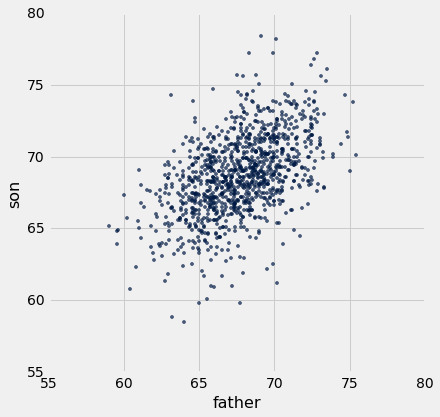

In [3]:
heights = Table.read_table('heights.csv')
heights.scatter('father', 'son', s=10)

Notice the familiar football shape with a dense center and a few points on the perimeter. This shape results from two bell-shaped distributions that are correlated. The heights of both fathers and sons have a bell-shaped distribution.

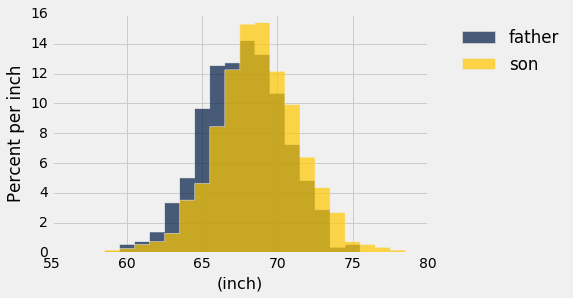

In [4]:
heights.hist(bins=np.arange(55.5, 80, 1), unit='inch')

The average height of sons is about an inch taller than the average of fathers.

In [5]:
np.mean(heights.column('son')) - np.mean(heights.column('father'))

0.99740259740261195

The difference in height between a son and a father varies as well, with the bulk of the distribution between -5 inches and +7 inches.

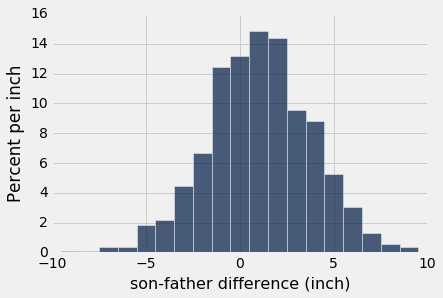

In [6]:
diffs = Table().with_column('son-father difference', 
                            heights.column('son') - heights.column('father'))
diffs.hist(bins=np.arange(-9.5, 10, 1), unit='inch')

The correlation between the heights of the fathers and sons is about 0.5.

In [7]:
r = correlation(heights, 'father', 'son')
r

0.50116268080759108

### The regression effect

For fathers around 72 inches in height, we might expect their sons to be tall as well. The histogram below shows the height of all sons of 72-inch fathers.

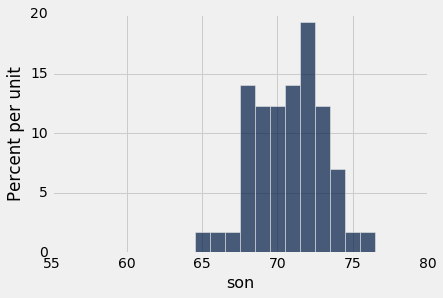

In [8]:
six_foot_fathers = heights.where(np.round(heights.column('father')) == 72)
six_foot_fathers.hist('son', bins=np.arange(55.5, 80, 1))

Most (68%) of the sons of these 72-inch fathers are *less than* 72 inches tall, even though sons are an inch taller than fathers on average!

In [9]:
np.count_nonzero(six_foot_fathers.column('son') < 72) / six_foot_fathers.num_rows

0.6842105263157895

In fact, the average height of a son of a 72-inch father is less than 71 inches. The sons of tall fathers are simply not as tall in this sample.

In [10]:
np.mean(six_foot_fathers.column('son'))

70.728070175438603

This fact was noticed by Galton, who had been hoping that exceptionally tall fathers would have sons who were just as exceptionally tall. However, the data were clear, and Galton realized that the tall fathers have sons who are not quite as exceptionally tall, on average. Frustrated, Galton called this phenomenon "regression to mediocrity." 

Galton also noticed that exceptionally short fathers had sons who were somewhat taller relative to their generation, on average. In general, individuals who are away from average on one variable are expected to be not quite as far away from average on the other. This is called the *regression effect*.

The figure below shows the scatter plot of the data when both variables are measured in standard units. The red line shows equal standard units and has a slope of 1, but it does not match the angle of the cloud of points. The blue line, which does follow the angle of the cloud, is called the *regression line*, named for the "regression to mediocrity" it predicts.

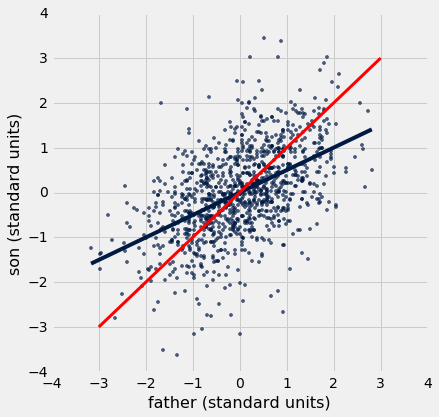

In [11]:
heights_standard = Table().with_columns([
        'father (standard units)', standard_units(heights['father']),
        'son (standard units)', standard_units(heights['son'])
        ])
heights_standard.scatter(0, fit_line=True, s=10)
_ = plots.plot([-3, 3], [-3, 3], color='r', lw=3)

The `scatter` method of a `Table` draws this regression line for us when called with `fit_line=True`. This line passes through the result of multiplying father heights (in standard units) by $r$.

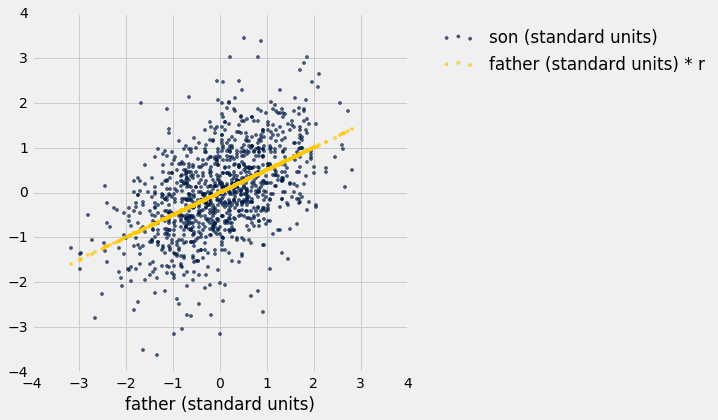

In [12]:
father_standard = heights_standard.column(0)
heights_standard.with_column('father (standard units) * r', father_standard * r).scatter(0, s=10)

Another interpretation of this line is that it passes through average values for slices of the population of sons. To see this relationship, we can round the fathers each to the nearest unit, then average the heights of all sons associated with these rounded values. The green line is the regression line for these data, and it passes close to all of the yellow points, which are mean heights of sons (in standard units).

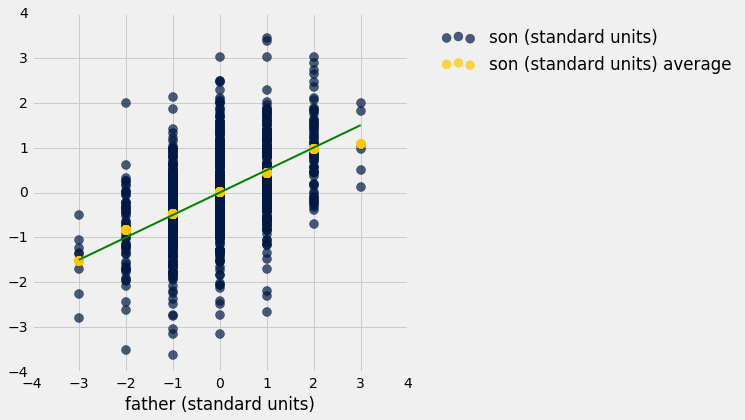

In [13]:
rounded = heights_standard.with_column('father (standard units)', np.round(father_standard))
rounded.join('father (standard units)', rounded.group(0, np.average)).scatter(0, s=80)
_ = plots.plot([-3, 3], [-3 * r, 3 * r], color='g', lw=2)

Karl Pearson used the observation of the regression effect in the data above, as well as in other data provided by Galton, to develop the formal calculation of the correlation coefficient $r$. That is why $r$ is sometimes called *Pearson's correlation*.

### The regression line in original units

As we saw in the last section for football shaped scatter plots, when the variables $x$ and $y$ are measured in standard units, the best straight line for estimating $y$ based on $x$ has slope $r$ and passes through the origin. Thus the equation of the regression line can be written as:

$$(\textit{y in standard units}) = r \times (\textit{x in standard units})$$

That is,
$$
\frac{\mbox{estimate of}~y ~-~\mbox{average of}~y}{\mbox{SD of}~y}
~=~ r \times 
\frac{\mbox{the given}~x ~-~\mbox{average of}~x}{\mbox{SD of}~x}
$$

The equation can be converted into the original units of the data, either by rearranging this equation algebraically, or by labeling some important features of the line both in standard units and in the original units.

![regline](../images/regline.png)

### Calculation of the slope and intercept

The regression line is also commonly expressed as a slope and an intercept, where an estimate for y is computed from an x value using the equation

$$y = \mbox{slope} \times x + \mbox{intercept}$$

The calculations of the slope and intercept of the regression line can be derived from the equation above.

In [14]:
def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

[slope(heights, 'father', 'son'), intercept(heights, 'father', 'son')]

[0.51400591254559247, 33.892800540661682]

It is worth noting that the intercept of approximately 33.89 inches is *not* intended as an estimate of the height of a son whose father is 0 inches tall. There is no such son and no such father. The intercept is merely a geometric or algebraic quantity that helps define the line. In general, it is not a good idea to *extrapolate*, that is, to make estimates outside the range of the available data. It is certainly not a good idea to extrapolate as far away as 0 is from the heights of the fathers in the study.

It is also worth noting that the slope *is not* `r`! Instead, it is `r` multiplied by the ratio of standard deviations.

In [15]:
correlation(heights, 'father', 'son')

0.50116268080759108

## Fitted values
We can also estimate every son in the data using the slope and intercept. The estimated values of $y$ are called the *fitted values*. They all lie on a straight line. To calculate them, take a son's height, multiply it by the slope of the regression line, and add the intercept. In other words, calculate the height of the regression line at the given value of $x$.

In [16]:
def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

fitted = heights.with_column('son (fitted)', fit(heights, 'father', 'son'))
fitted

father,son,son (fitted)
65,59.8,67.3032
63.3,63.2,66.4294
65,63.3,67.3032
65.8,62.8,67.7144
61.1,64.3,65.2986
63,64.2,66.2752
65.4,64.1,67.5088
64.7,64,67.149
66.1,64.6,67.8686
67,64,68.3312


In original units, we can see that these fitted values fall on a line.

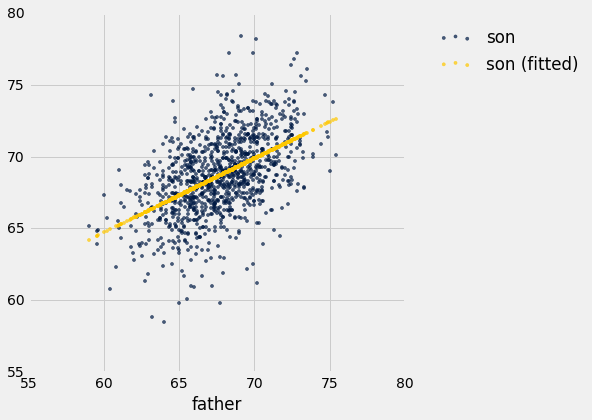

In [17]:
fitted.scatter(0, s=10)

Moreover, this line (in green below), passes near the average heights of sons for slices of the population. In this case, we round the heights of fathers to the nearest inch to construct the slices.

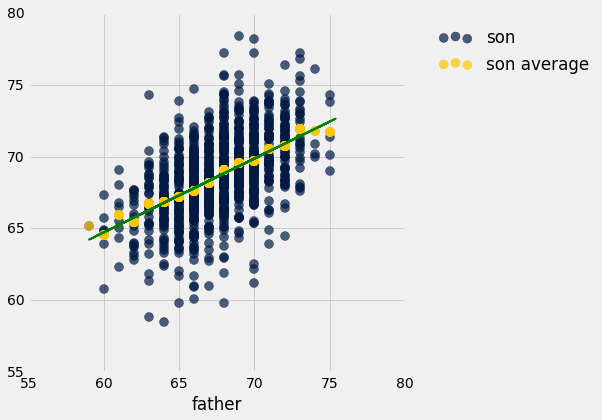

In [18]:
rounded = heights.with_column('father', np.round(heights.column('father')))
rounded.join('father', rounded.group(0, np.average)).scatter(0, s=80)
_ = plots.plot(fitted.column('father'), fitted.column('son (fitted)'), color='g', lw=2)

### Residuals

The amount of error in each of these regression estimates is the difference between the son's height and its estimate. These errors are called *residuals*. Some residuals are positive. These correspond to points that are above the regression line – points for which the regression line under-estimates $y$. Negative residuals correspond to the line over-estimating values of $y$.

In [19]:
res = fitted.with_column('residual', fitted.column('son') - fitted.column('son (fitted)'))
res

father,son,son (fitted),residual
65,59.8,67.3032,-7.50318
63.3,63.2,66.4294,-3.22937
65,63.3,67.3032,-4.00318
65.8,62.8,67.7144,-4.91439
61.1,64.3,65.2986,-0.998562
63,64.2,66.2752,-2.07517
65.4,64.1,67.5088,-3.40879
64.7,64,67.149,-3.14898
66.1,64.6,67.8686,-3.26859
67,64,68.3312,-4.3312


As with deviations from average, the positive and negative residuals exactly cancel each other out. So the average (and sum) of the residuals is 0.

## Residual plots

Suppose you have carried out the regression of sons' heights on fathers' heights.

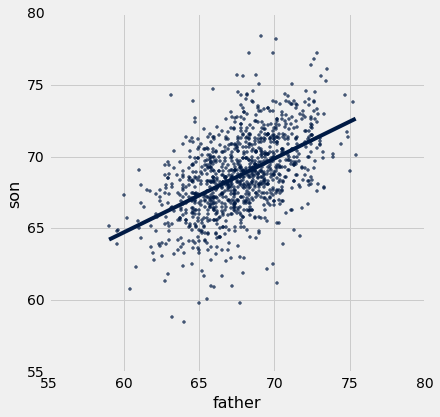

In [20]:
heights.scatter('father', 'son', fit_line=True, s=8)

It is a good idea to then draw a residual plot, a scatter plot of the residuals versus the values of $x$. The residual plot of a good regression looks like the one below: a formless cloud with no pattern, centered around the horizontal axis. It shows that there is no discernible non-linear pattern in the original scatter plot.

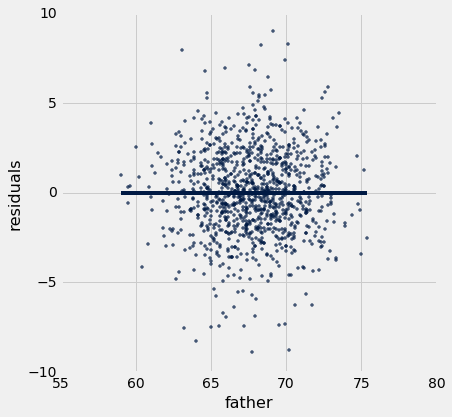

In [21]:
def residual_plot(table, x, y):
    """Plot the residuals (errors) of regression."""
    residuals = table.column(y) - fit(table, x, y)
    table.select(x).with_column('residuals', residuals).scatter(x, fit_line=True, s=8)
    
residual_plot(heights, 'father', 'son')

Residual plots can be useful for spotting non-linearity in the data, or other features that weaken the regression analysis. For example, consider the SAT data of the previous section, and suppose you try to estimate the ``Combined`` score based on ``Participation Rate``.

In [22]:
sat2014 = Table.read_table('sat2014.csv')
sat2014

State,Participation Rate,Critical Reading,Math,Writing,Combined
North Dakota,2.3,612,620,584,1816
Illinois,4.6,599,616,587,1802
Iowa,3.1,605,611,578,1794
South Dakota,2.9,604,609,579,1792
Minnesota,5.9,598,610,578,1786
Michigan,3.8,593,610,581,1784
Wisconsin,3.9,596,608,578,1782
Missouri,4.2,595,597,579,1771
Wyoming,3.3,590,599,573,1762
Kansas,5.3,591,596,566,1753


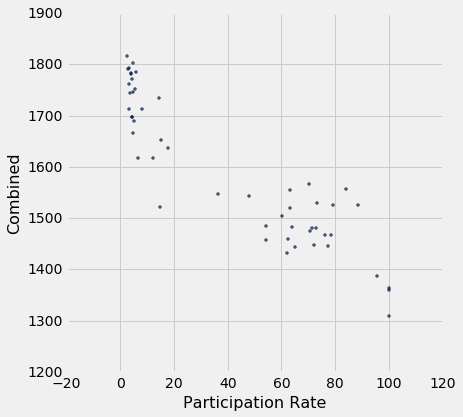

In [23]:
sat2014.scatter('Participation Rate', 'Combined', s=8)

The relation between the variables is clearly non-linear, but you might be tempted to fit a straight line anyway, especially if you never looked at a scatter diagram of the data.

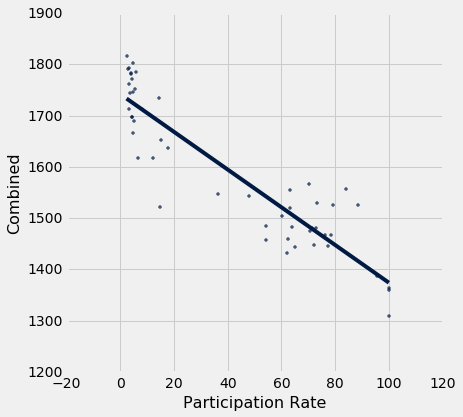

In [24]:
sat2014.scatter('Participation Rate', 'Combined', s=8, fit_line=True)

The points in the scatter plot start out above the regression line, then are consistently below the line, then above, then below. This pattern of non-linearity is more clearly visible in the residual plot.

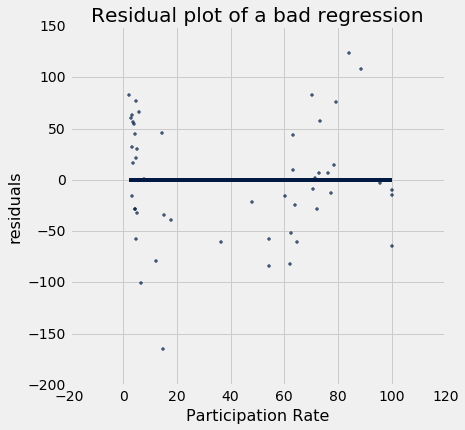

In [25]:
residual_plot(sat2014, 'Participation Rate', 'Combined')
_ = plots.title('Residual plot of a bad regression')

This residual plot is not a formless cloud; it shows a non-linear pattern, and is a signal that linear regression should not have been used for these data.

### The rough size of the residuals

Let us return to the heights of the fathers and sons, and investigate the estimates based on using the regression line and the flat line (in yellow) at the average height of the sons. As noted above, the rough size of the errors made using the flat line is the SD of $y$. The regression line appears to do a better job of estimating sons' heights than the flat line does. Thus, the rough size of the errors made using the regression line must be smaller that that using the flat line. In other words, the SD of the residuals must be smaller than the overall SD of $y$.

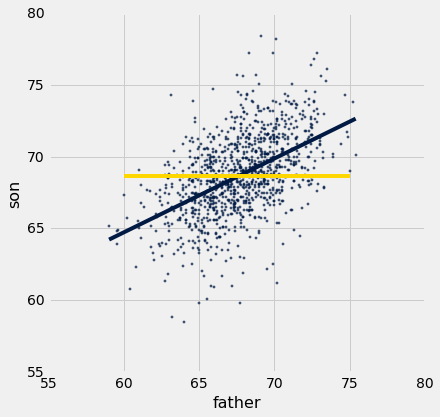

In [26]:
heights.scatter('father', 'son', s=5, fit_line=True)
average_son = np.mean(heights.column('son'))
_ = plots.plot([60, 75], [average_son, average_son], lw=4, color='gold')

Here, once again, are the residuals in the estimation of sons' heights based on fathers' heights. Each residual is the difference between the height of a son and his estimated (or "fitted") height.

In [27]:
res

father,son,son (fitted),residual
65,59.8,67.3032,-7.50318
63.3,63.2,66.4294,-3.22937
65,63.3,67.3032,-4.00318
65.8,62.8,67.7144,-4.91439
61.1,64.3,65.2986,-0.998562
63,64.2,66.2752,-2.07517
65.4,64.1,67.5088,-3.40879
64.7,64,67.149,-3.14898
66.1,64.6,67.8686,-3.26859
67,64,68.3312,-4.3312


The average of the residuals is 0. All the negative errors exactly cancel out all the positive errors.

The standard deviation of the residuals is about 2.4 inches, while the overall SD of the sons' heights is about 2.8 inches. As expected, the SD of the residuals is smaller than the overall SD of $y$.

In [28]:
np.std(res.column('residual'))

2.4358716091393409

In [29]:
np.std(res.column('son'))

2.8148875206879027

By what factor? Another remarkable fact of mathematics is that no matter what the data look like, the SD of the residuals is $\sqrt{1-r^2}$ times the SD of $y$.

In [30]:
np.std(res.column('residual'))/np.std(res.column('son'))

0.86535308826267487

In [31]:
np.sqrt(1 - r**2)

0.86535308826267476

### Average and SD of the Residuals
**Regardless of the shape of the scatter plot:**

average of the residuals = 0

SD of the residuals $~=~ \sqrt{1 - r^2} \cdot \mbox{SD of}~y$

The residuals are equal to the values of $y$ minus the fitted values. Since the average of the residuals is 0, the average of the fitted values must be equal to the average of $y$.

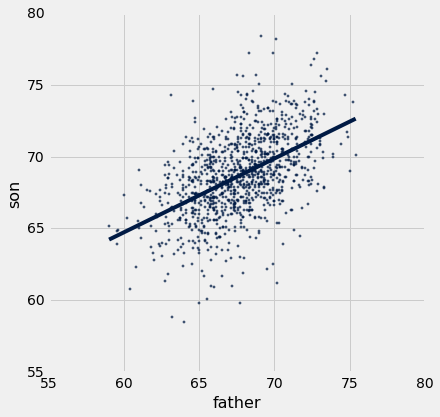

In [32]:
heights.scatter('father', 'son', fit_line=True, s=5)

The SD of the fitted values is smaller than the overall SD of $y$. The fitted values range from about 64 to about 73, whereas the values of $y$ range from about 58 to 77.

So if we take the ratio of the SD of the fitted values to the SD of $y$, we expect to get a number between 0 and 1. And indeed we do: a very special number between 0 and 1.

In [33]:
np.std(res.column('son (fitted)'))/np.std(res.column('son'))

0.50116268080759108

In [34]:
correlation(heights, 'father', 'son')

0.50116268080759108

Here is the final remarkable fact of mathematics in this section:

### Average and SD of the Fitted Values
**Regardless of the shape of the scatter plot:**

average of the fitted values = the average of $y$

SD of the fitted values $~=~ |r| \cdot$ SD of $y$

Notice the absolute value of $r$ in the formula above. For the heights of fathers and sons, the correlation is positive and so there is no difference between using $r$ and using its absolute value. However, the result is true for variables that have negative correlation as well, provided we are careful to use the absolute value of $r$ instead of $r$.